# Human proteins Network



In [1]:
import csv
import scipy 
from scipy import sparse
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from collections import defaultdict
import random

The following lines of code are used to import the adjacency matrix of the human proteins network. 
Then, a scipy sparse matrix is created to store such matrix.

### Import Adjacency matrix

In [2]:
class Network():
    
    def __init__(self,filename):
        self.filename = filename
        self.import_Network()
        
    def import_Network(self):

        list_rows=[]

        with open(self.filename) as tsvfile:
            reader = csv.DictReader(tsvfile, dialect='excel-tab')
            for row in reader:
                s = row['% asym unweighted'].split()
                list_rows.append(list(map(int, s)) )
    
        vals = np.array(list_rows)

        self.row = vals[:,0]
        self.col = vals[:,1]
        self.data = np.ones(vals.shape[0])
        self.num_vertices = int(np.max(self.col)) + 1
        self.num_edges = int(np.sum(self.data))
        
        
        self.adjacency = scipy.sparse.csr_matrix( (self.data, (self.row,self.col)), 
                                                 shape = (self.num_vertices,self.num_vertices))
        self.set_laplacian_matrix()
        
        
    def set_laplacian_matrix(self):
        out_degree = self.get_outdegree()
        
        self.laplacian = scipy.sparse.lil_matrix((self.num_vertices,self.num_vertices))
        self.laplacian.setdiag(np.array(out_degree).flatten())
        self.laplacian = self.laplacian - scipy.sparse.lil_matrix(self.adjacency)
        self.laplacian = scipy.sparse.csr_matrix(self.laplacian)        
        
        
    def get_indegree(self):
        degs = self.adjacency.sum(axis = 0)
        return degs.flatten()
    
    def get_outdegree(self):
        degs = self.adjacency.sum(axis = 1)
        return degs.flatten()
    

net = Network('out.maayan-figeys')


## Dynamics of the network

In this section we are going to implement a dynamical evolution of the network states. Since our network consists of the interaction of proteins, we choose a popular dynamics in Biological regulatory systems: a **Boolean Network**. 

In this scenario, the state of each node can be either 0 or 1. These states have biological meaning. For example, the state 1 may mean that the protein has been expressed, while state 0 may mean otherwise. The evolution of the system is the following.

Initially, all the nodes are initialized at random.The state of node $i$ at time $t+1$ is given by

$$
\sigma_i(t+1) = f(\sigma_{1}(t), \cdots, \sigma_{N}(t))
$$

where $N$ is the number of nodes of the network. The function $f$ depends on the biological system. In this case we are going to use the **Majority voting** dynamics. This function assigns to state $i$ the most common state among all the states from nodes which link to node $i$. Therefore, in this case:

$$
\sigma_i(t+1) = \text{majority_voting}(\sigma_{j_1}(t), \cdots, \sigma_{j_k}(t))
$$

Where nodes $j_1, \cdots, j_k$ link to node $i$. 

In [3]:
G = nx.from_scipy_sparse_matrix(net.adjacency, create_using = nx.DiGraph())

In [71]:
class Boolean_Dynamics:
    def __init__(self,G, print_proportion=True):
        """
        Class that implements a Boolean Network's dynamics.
        Args:
            G (networkX Digraph): Directed graph
            print_proportion (bool): Whether to print the proportion of 1's 
            
        Attributes:
            G (networkX Digraph): Directed graph
            old_states (numpy array): Array of states for time t-1
            stop (bool): If true, the dynamics finishes
            stopping_criteria_met (str): stopping criteria that has ceased the dynamics
            finishing_time (int): number of time steps performed until the stopping criterion is met 
            counter (int): Number of times the proportion of changed states has not changed
            count_max (int): Maximum value of the counter before stoping the dynamical evolution
            MeanDegree_top5 (double): mean of the top 5 degrees of the nodes initialized at value 1
        """
        self.G = G
        self.initialize()
        self.old_states = np.array([self.G.nodes[node]['state'] for node in self.G.nodes])
        if print_proportion:
            print('Proportion of 1ns ', np.mean(self.old_states))
        self.stop = False
        self.stopping_criteria_met = None
        self.finishing_time = None
        self.counter = 0
        self.count_max = 10
        
        select_all_nodes = [self.G.degree[node] for node in self.G.nodes] 
        select_all_nodes.sort(reverse=True)
        get_mean_top5 = np.mean(select_all_nodes[:5])
        select_nodes_1 = [self.G.degree[node] for node in self.G.nodes if self.G.nodes[node]['state'] == 1]  
        select_nodes_1.sort(reverse=True)
        self.MeanDegree_top5 = np.mean(select_nodes_1[:5])/get_mean_top5
        
    
    def initialize(self):
        """
        Initializes the nodes' states randomly to 0 or 1
        """
        # Remove nodes with no incoming edges
        removal = []
        for i in self.G.nodes:
            edges_tuple = list(self.G.in_edges(i)) # Get incoming edges to node i
            if len(edges_tuple)==0: 
                removal.append(i)
        for i in removal:
            self.G.remove_node(i)
                
        # Random states        
        for i in self.G.nodes:  
            self.G.nodes[i]['state']= 1 if random.uniform(0, 1) <0.5 else 0
        
        # Initial state according to degrees
        # l =list(dict(self.G.degree).values())
        # l2 = l.copy()
        # l2.sort(reverse=True)
        # max_deg = l2[2]

        # k = 0
        #for i in self.G.nodes:  
        #    self.G.nodes[i]['state']= 1 if l[k]<=max_deg else 0
        #    k+=1
        
    
    def update(self,i, new_G):
        """
        Given a node i, it updates its state based on the states of its linked nodes
        Args:
            i (int): Node to be updated
            new_G (networkX digraph): Graph at time t+1 (self.G is graph at time t)
        """
        edges_tuple = list(self.G.in_edges(i)) # Get incoming edges to node i
        in_nodes = [ed[0] for ed in edges_tuple] # Get the nodes of these edges
        states = [self.G.nodes[node]['state'] for node in in_nodes] # Get the states of such nodes
        if len(states)==0:
            final_state = self.G.nodes[i]['state']
        else:
            final_state = 0 if np.mean(states)<0.5 else 1 # Update the state of node i using majority voting
        #print(final_state, states)
        new_G.nodes[i]['state'] = final_state
    
    def stopping(self,prop,old_prop, time, t_max, save_info=True):
        """
        Stopping criteria
        Args:
            prop (float): If the proportion of changed states is less than  prop, stop the dynamics
            old_prop (float): Proportion of previous iteration
            time (int): time step
            t_max (int): Maximum number of time steps
        Returns:
            true_prop (float): Proportion of changed states from time t to time t+1
        """
        # We stop the dynamics if the proportion of changed states is less than prop
        # Or if the proportion of changing states stabilizes
        # Or if we reach a maximum number of iterations
        
        # Get the current states
        new_states = np.array([self.G.nodes[node]['state'] for node in self.G.nodes])
        dif = abs(self.old_states - new_states)
        # Calculate the absolute difference with the old states to see how many of them have
        # changed in this time step
        true_prop = np.mean(dif)
        if true_prop<prop: # If the proportion of changed states is smaller than prop, stop
            self.stop = True
            if save_info:
                self.stopping_criteria_met = 'proportion'
        self.old_states = new_states
        # If the proportion of changed states is the same as in the last iteration, increase the counter
        if true_prop==old_prop:
            self.counter+=1
            if self.counter>self.count_max: # If the counter reaches the maximum value, stop
                self.stop = True  
                if save_info:
                    self.stopping_criteria_met = 'stabilization'
        else:
            self.counter=0
        # If we reach the maximum number of time steps, stop the process
        if time>=t_max:
                self.stop = True
                if save_info:
                    self.stopping_criteria_met = 'iterations'
                #print("Maximum time reached")
        return true_prop
    
    def run(self,display_step = 1, prop = 0.0001, t_max = 1000, count_max = 10, print_info=True, save_info = True):
        """
        Dynamics evolution
        Args:
            display_step (int): Number of iterations to wait until displaying the current result
            prop (float): Maximal proportion of changed states to stop the dynamics
            t_max (float): Maximum number of iterations
            count_max (int): Maximum value of the counter before stoping the dynamical evolution
            print_info (bool): Whether to print the proportion of changing states and the final dynamics information 
        Return:
            G (networkX digraph): Graph containig the states
        """
        self.stop =False
        time = 0
        true_prop = 0
        self.count_max = count_max
        while not self.stop:
            new_G = self.G.copy()
            for i in self.G.nodes:
                self.update(i, new_G)
            self.G = new_G.copy()
            true_prop = self.stopping(prop, true_prop, time, t_max, save_info)
            time+=1
            if print_info:
                if time%display_step==0:
                    print("Time: ", time, "Proportion of changing states: ", true_prop)
        
        if save_info:
            self.finishing_time = time
        if print_info:
            print("Dynamics finished at time ", time, " with proportion of changing states ", true_prop)
        return self.G
    
    def get_final_states(self,print_states = True):
        G_dyn = self.run(print_info=False)
        final_states = np.array([G_dyn.nodes[node]['state'] for node in G_dyn.nodes])
        G_dyn2 = self.run(t_max =0,print_info=False, save_info = False)
        final_states2 = np.array([G_dyn2.nodes[node]['state'] for node in G_dyn2.nodes])
        G_dyn3 = self.run(t_max =0,print_info=False, save_info=False)
        final_states3 = np.array([G_dyn3.nodes[node]['state'] for node in G_dyn3.nodes])

        true_states = np.copy(final_states)
        true_states[(final_states!=final_states2)*(final_states==final_states3)] = 2
        if np.sum(final_states!=final_states3)!=0:
            print('Periodic orbits with higher period')
        if print_states:
            print("Final proportion of 1: ", np.sum(true_states==1)/len(true_states))
            print("Final proportion 0: ", np.sum(true_states==0)/len(true_states))
            print("Final proportion of periodic orbits: ",np.sum(true_states==2)/len(true_states))

        return true_states


In [72]:
Boolean = Boolean_Dynamics(G)

Proportion of 1ns  0.5186991869918699


In [73]:
G_dyn = Boolean.run()

Time:  1 Proportion of changing states:  0.4764227642276423
Time:  2 Proportion of changing states:  0.4861788617886179
Time:  3 Proportion of changing states:  0.5349593495934959
Time:  4 Proportion of changing states:  0.4926829268292683
Time:  5 Proportion of changing states:  0.5203252032520326
Time:  6 Proportion of changing states:  0.4682926829268293
Time:  7 Proportion of changing states:  0.432520325203252
Time:  8 Proportion of changing states:  0.3154471544715447
Time:  9 Proportion of changing states:  0.27967479674796747
Time:  10 Proportion of changing states:  0.2780487804878049
Time:  11 Proportion of changing states:  0.2780487804878049
Time:  12 Proportion of changing states:  0.2780487804878049
Time:  13 Proportion of changing states:  0.2780487804878049
Time:  14 Proportion of changing states:  0.2780487804878049
Time:  15 Proportion of changing states:  0.2780487804878049
Time:  16 Proportion of changing states:  0.2780487804878049
Time:  17 Proportion of changing 

In [74]:
final_states = Boolean.get_final_states()

Final proportion of 1:  0.6471544715447154
Final proportion 0:  0.07479674796747968
Final proportion of periodic orbits:  0.2780487804878049


## Analysis of the dynamics

Let us now analyze the evolution of such dynamics in our network. That is, we want to infer whether it finishes with a consensus or with different, but robust, groups of 0's and 1's. 

In the experiment run above, we saw that the dynamical process ended due to an stabilization of the proportion of changes. The final state can be one of this three values:

+ **0**: The boolean stable state 0
+ **1**: The boolean stable state 1
+ **2**: A stable periodic orbit 0-1 (with period 1)

In the previous example we obtained a 60% of ones, a 25% of zeros and a 15% of periodic orbits. Therefore, the network did not achieve *consensus*. We will now analyze whether such groups of nodes are robust or not. In order to do so, we are going to independently run this dynamics through our network many times and, for each of them, we will get the mean of the final states as well as the stopping criterion met. 

In [54]:
def independent_experiments(n):
    prop1 = []
    propOrbits = []
    stopping_criterion = []
    time_finishing = []

    for i in np.arange(n):
        Boolean = Boolean_Dynamics(G, print_proportion=False)
        final_states = Boolean.get_final_states(print_states = False)
    
        prop1.append(np.sum(final_states==1)/len(final_states))
        propOrbits.append(np.sum(final_states==2)/len(final_states))
        stopping_criterion.append(Boolean.stopping_criteria_met)
        time_finishing.append(Boolean.finishing_time)
        
        
    #plots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(prop1,'o')
    axs[0].set_title('Proportion of 1ns for {} experiments'.format(n))
    axs[0].set(xlabel="experiments' execution", ylabel="mean of the final states")
    axs[0].set_ylim([0,1])
    axs[1].plot(propOrbits,'o')
    axs[1].set_title('Proportion of periodic orbits for {} experiments'.format(n))
    axs[1].set(xlabel="experiments' execution", ylabel="mean of the final states")
    axs[1].set_ylim([0,1])
    axs[2].plot(1 - np.array(prop1) - np.array(propOrbits),'o')
    axs[2].set_title('Proportion of 0s for {} experiments'.format(n))
    axs[2].set(xlabel="experiments' execution", ylabel="mean of the final states")
    axs[2].set_ylim([0,1])
    plt.show()
    
    plt.plot(time_finishing,'o')
    plt.title('Number of iterations for {} experiments'.format(n))
    plt.xlabel("experiments' execution")
    plt.ylabel("number of iterations")
    
    plt.show()
    print("MEAN PROPORTIONS OF FINAL STATES")
    print('Mean proportion of 1ns ', np.mean(prop1))
    print('Mean proportion of 0s ', 1. - np.mean(prop1) - np.mean(propOrbits))
    print('Mean proportion of periodic orbits ', np.mean(propOrbits))
    
    #stopping criterions
    stab = stopping_criterion.count('stabilization')
    prop = stopping_criterion.count('proportion')
    iterat = stopping_criterion.count('iterations')
    print('\nSTOPPING CRITERIONS MET IN THE EXPERIMENTS')
    print('Small proportion of changes: {}%'.format((prop/n)*100))
    print('Stabilization: {}%'.format((stab/n)*100))
    print('Reaching the maximum number of iterations allowed: {}%'.format((iterat/n)*100))
    

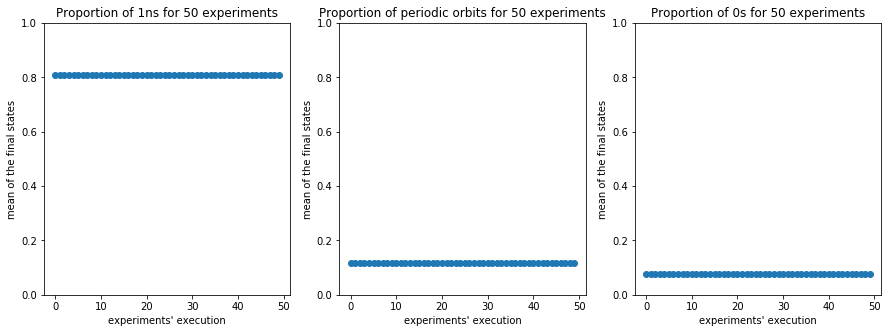

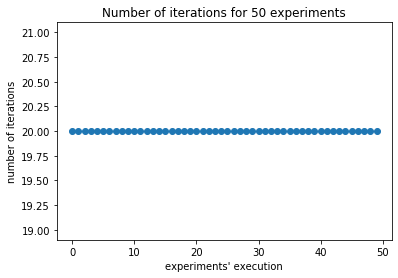

MEAN PROPORTIONS OF FINAL STATES
Mean proportion of 1ns  0.808130081300813
Mean proportion of 0s  0.07479674796747968
Mean proportion of periodic orbits  0.11707317073170734

STOPPING CRITERIONS MET IN THE EXPERIMENTS
Small proportion of changes: 0.0%
Stabilization: 100.0%
Reaching the maximum number of iterations allowed: 0.0%


In [55]:
independent_experiments(50)

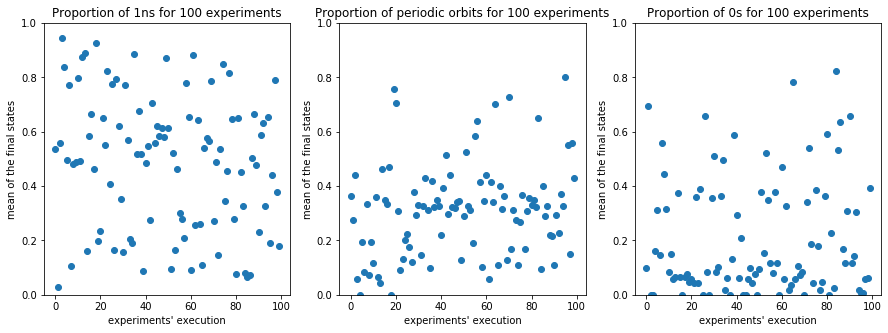

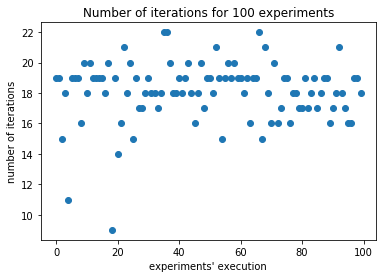

MEAN PROPORTIONS OF FINAL STATES
Mean proportion of 1ns  0.4850081300813007
Mean proportion of 0s  0.20404878048780495
Mean proportion of periodic orbits  0.3109430894308943

STOPPING CRITERIONS MET IN THE EXPERIMENTS
Small proportion of changes: 2.0%
Stabilization: 98.0%
Reaching the maximum number of iterations allowed: 0.0%


In [135]:
independent_experiments(100)

At first glance, the most remarkable fact is the wide variety of values for the mean of the final states. However, it is important to notice that, in almost all the experiments, the stopping criterion met was *stabilization*. That is, the process ended because the proportion of changed states was the same for 10 consecutive iterations ( that we had reached a stable state of either attractor points or periodic orbits). Notice that in none of the experiments the stopping criterion has been "reaching the maximum number of iterations allowed". Another interesing feature is the fact that, in almost all the cases, the number of iterations performed was within the interval [15,22].

By looking at the proportion of 1ns, 0s and periodic orbits, we can see that the dynamics is not robust, but it highly depends on the initial values of the experiment. Nontheless, if we look at the average of the proportion of  the final states, we see that the around half of the states end up with state 1, and around one third of the states end up with a periodic orbit. Therefore, it seems that the final state of the system is not completely random.

Let us now check whether the inicialization influentiates the result according to the nodes' degree. In order to do so, we are going to slightly modify the previous function. At this time, we are going to take the five nodes initialized at 1 with highest degree and we will compute its mean. Then, such mean is going to be normalized by being divided by the mean of the top 5 degrees of the network. This normalized mean is going to be plotted along with the proportion of 1ns in the final states.

In [146]:
def independent_experiments(n):
    prop1 = []
    propOrbits = []
    stopping_criterion = []
    time_finishing = []
    MeanDegree_top5 = []

    for i in np.arange(n):
        Boolean = Boolean_Dynamics(G, print_proportion=False)
        final_states = Boolean.get_final_states(print_states = False)
    
        prop1.append(np.sum(final_states==1)/len(final_states))
        propOrbits.append(np.sum(final_states==2)/len(final_states))
        stopping_criterion.append(Boolean.stopping_criteria_met)
        time_finishing.append(Boolean.finishing_time)
        MeanDegree_top5.append(Boolean.MeanDegree_top5)
        
        
    #plots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    SM, = axs[0].plot(prop1, 'o')
    MD, = axs[0].plot(MeanDegree_top5, 'x')
    axs[0].set_title('Proportion of 1ns for {} experiments'.format(n))
    axs[0].set(xlabel="experiments' execution", ylabel="mean of the final states")
    axs[0].set_ylim([0,1])
    axs[0].legend([SM, MD],["Mean final states", "Mean degree"])
    major_ticks = np.arange(0, n, 10)
    minor_ticks = np.arange(0, n, 1)
    axs[0].set_xticks(major_ticks)
    axs[0].set_xticks(minor_ticks, minor=True)
    axs[0].xaxis.grid(which='minor', alpha=0.5)
    axs[0].xaxis.grid(which='major', alpha=0.5)
    
    SM2, = axs[1].plot(propOrbits, 'o')
    MD2, = axs[1].plot(MeanDegree_top5, 'x')
    axs[1].set_title('Proportion of periodic orbits{} experiments'.format(n))
    axs[1].set(xlabel="experiments' execution", ylabel="mean of the final states")
    axs[1].set_ylim([0,1])
    axs[1].legend([SM2, MD2],["Mean final states", "Mean degree"])
    major_ticks = np.arange(0, n, 10)
    minor_ticks = np.arange(0, n, 1)
    axs[1].set_xticks(major_ticks)
    axs[1].set_xticks(minor_ticks, minor=True)
    axs[1].xaxis.grid(which='minor', alpha=0.5)
    axs[1].xaxis.grid(which='major', alpha=0.5)
    
    
    SM3, = axs[2].plot(1. - np.array(propOrbits) - np.array(prop1), 'o')
    MD3, = axs[2].plot(MeanDegree_top5, 'x')
    axs[2].set_title('Proportion of 0s for {} experiments'.format(n))
    axs[2].set(xlabel="experiments' execution", ylabel="mean of the final states")
    axs[2].set_ylim([0,1])
    axs[2].legend([SM3, MD3],["Mean final states", "Mean degree"])
    major_ticks = np.arange(0, n, 10)
    minor_ticks = np.arange(0, n, 1)
    axs[2].set_xticks(major_ticks)
    axs[2].set_xticks(minor_ticks, minor=True)
    axs[2].xaxis.grid(which='minor', alpha=0.5)
    axs[2].xaxis.grid(which='major', alpha=0.5)
    plt.show()
    
    plt.plot(time_finishing,'o')
    plt.title('Number of iterations for {} independent experiments'.format(n))
    plt.xlabel("experiments' execution")
    plt.ylabel("number of iterations")
    plt.show()
    
    # Mean values
    print("MEAN PROPORTIONS OF FINAL STATES")
    print('Mean proportion of 1ns ', np.mean(prop1))
    print('Mean proportion of 0s ', 1. - np.mean(prop1) - np.mean(propOrbits))
    print('Mean proportion of periodic orbits ', np.mean(propOrbits))
    
    #stopping criterions
    stab = stopping_criterion.count('stabilization')
    prop = stopping_criterion.count('proportion')
    iterat = stopping_criterion.count('iterations')
    print('\nSTOPPING CRITERIONS MET IN THE EXPERIMENTS')
    print('Small proportion of changes: {}%'.format((prop/n)*100))
    print('Stabilization: {}%'.format((stab/n)*100))
    print('Reaching the maximum number of iterations allowed: {}%'.format((iterat/n)*100))

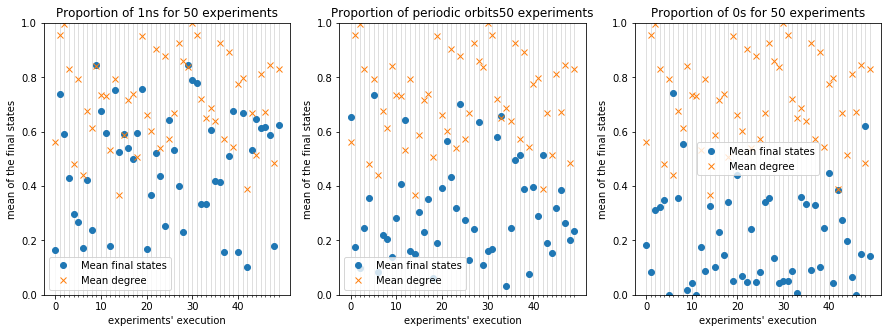

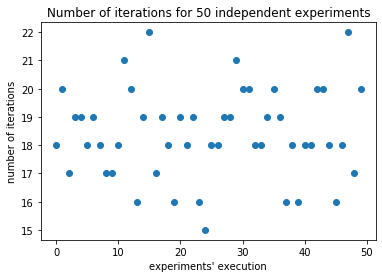

MEAN PROPORTIONS OF FINAL STATES
Mean proportion of 1ns  0.4803577235772357
Mean proportion of 0s  0.2042601626016261
Mean proportion of periodic orbits  0.3153821138211382

STOPPING CRITERIONS MET IN THE EXPERIMENTS
Small proportion of changes: 0.0%
Stabilization: 100.0%
Reaching the maximum number of iterations allowed: 0.0%


In [147]:
independent_experiments(50)

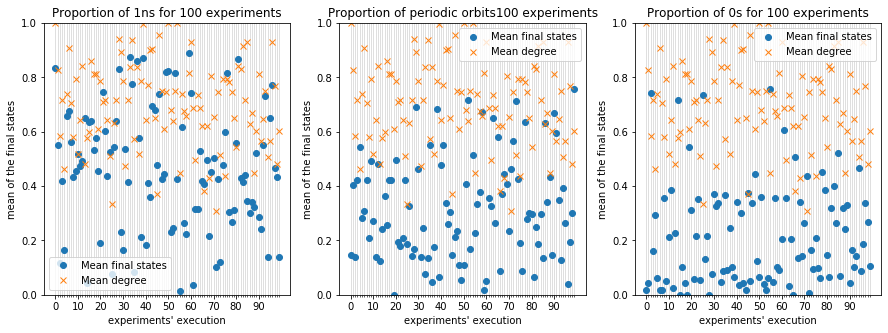

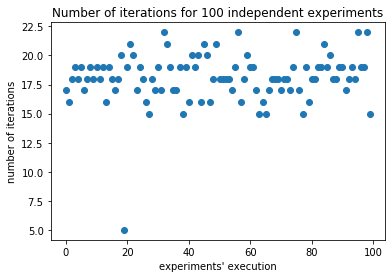

MEAN PROPORTIONS OF FINAL STATES
Mean proportion of 1ns  0.4668617886178862
Mean proportion of 0s  0.21463414634146338
Mean proportion of periodic orbits  0.31850406504065043

STOPPING CRITERIONS MET IN THE EXPERIMENTS
Small proportion of changes: 1.0%
Stabilization: 99.0%
Reaching the maximum number of iterations allowed: 0.0%


In [148]:
independent_experiments(100)

By looking at these experiments, we infer that the result of the dynamics does not depend on the initialization of the nodes with higher degree. We can see that high values of the degree's mean do not imply any particular behavior of the final states proportion.

In fact, this behavior is not that surprising. As we have already seen in other tasks, the degree distribution of our network follows a power law. Therefore, the huge majority of nodes have very few links. In addition, the criterion for updating the value of a node is the majority voting, but such voting is not performed in any particular order. 

Therfore, we can conclude that this Boolean dynamics updated by means of the majority voting criterion is not robust on our network.

### Spatial distribution of final states

Finally, we can see if there is any spatial distribution for the final states. That is, we will see if we can graphically identify regions with more density of zeros or ones or periodic orbits.

Final proportion of 1:  0.5804878048780487
Final proportion 0:  0.14471544715447154
Final proportion of periodic orbits:  0.27479674796747966


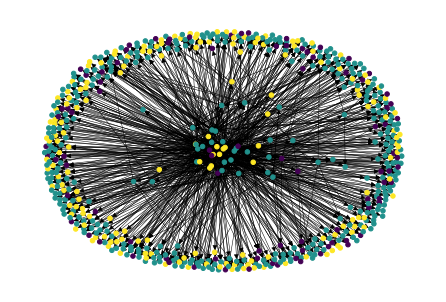

In [150]:
final_states = Boolean.get_final_states()

nx.draw(G, pos=nx.spring_layout(G), width = 0.5, 
        node_size=20, node_color = final_states)

In general, we do not see any special spatial distribution for the final states.